In [1]:
import json

# load the subset of the dataset
data = json.load(open('../data/visdial_1.0_train_subset.json'))['data']
dialogs = data['dialogs']
image_paths = [index['image_id'] for index in data['dialogs']]

In [42]:
import matplotlib.image as mpimg
from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt
import torch
import os
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
%matplotlib inline
setup_logger()
import numpy as np

def show_instance(instance_path):
    plt.imshow(mpimg.imread(instance_path))
    plt.axis('off')

def instance_segmentation(instance):
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.DEVICE = "cpu" # because we don't have a GPU
    predictor = DefaultPredictor(cfg)
    outputs = predictor(instance)
    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    # print(outputs["instances"].pred_classes)
    # print(outputs["instances"].pred_boxes)
    return cfg, outputs

def visualize_segments(instance, cfg, outputs):
    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(instance[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # tf.keras.utils.array_to_img(out.get_image()[:, :, ::-1]).show()
    plt.imshow(out.get_image()[:, :, ::-1]).set_cmap('hot')
    plt.axis('off')


# show original and with instance segmentation
def segmentations(instance_path):
    instance = cv2.imread(instance_path)
    cfg, outputs = instance_segmentation(instance)
    # show images side by side
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    show_instance(instance_path)  # original image
    f.add_subplot(1, 2, 2)
    visualize_segments(instance, cfg, outputs)  # segmented image
    plt.show(block=True)
    return outputs

# for each box
def get_axes_from_boxes(bounding_boxes):
    x = int(bounding_boxes.tensor.cpu().numpy()[0][0])
    y = int(bounding_boxes.tensor.cpu().numpy()[0][1])
    x_h = int(bounding_boxes.tensor.cpu().numpy()[0][2])
    y_h = int(bounding_boxes.tensor.cpu().numpy()[0][3])
    return [y, y_h, x, x_h]

/home/nishan/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


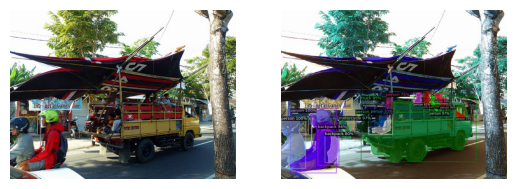

In [3]:
# showing an example image alongside the prediction boxes
output_boxes = segmentations(image_paths[0])

(-0.5, 129.5, 180.5, -0.5)

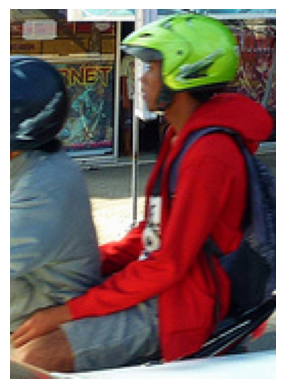

In [37]:
result = get_axes_from_boxes(output_boxes["instances"].pred_boxes[0])
y = result[0]
y_h = result[1]
x = result[2]
x_h = result[3]
plt.imshow(np.flip(cv2.imread(image_paths[0])[y:y_h, x:x_h], axis=-1)) # np.flip to convert from BGR to RGB
plt.axis('off')

(-0.5, 67.5, 144.5, -0.5)

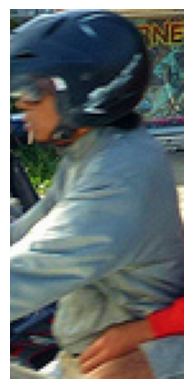

In [54]:
result = get_axes_from_boxes(output_boxes["instances"].pred_boxes[1])
y = result[0]
y_h = result[1]
x = result[2]
x_h = result[3]
# np.flip to convert from BGR to RGB
plt.imshow(np.flip(cv2.imread(image_paths[0])[y:y_h, x:x_h], axis=-1))
plt.axis('off')


In [48]:
all_results = []
for index in range(len(output_boxes["instances"].pred_boxes)):
    result = get_axes_from_boxes(output_boxes["instances"].pred_boxes[index])
    all_results.append([[result[2], result[0]], [result[3], result[1]]])
all_results

[[[26, 281], [156, 462]],
 [[0, 304], [68, 449]],
 [[419, 246], [452, 289]],
 [[164, 303], [196, 367]],
 [[211, 285], [254, 348]],
 [[226, 246], [552, 431]],
 [[450, 249], [471, 275]],
 [[103, 327], [164, 440]],
 [[403, 232], [425, 272]],
 [[247, 288], [315, 354]],
 [[436, 238], [455, 270]],
 [[375, 236], [398, 266]],
 [[124, 347], [162, 433]],
 [[297, 236], [315, 304]],
 [[494, 278], [520, 306]],
 [[436, 237], [452, 256]],
 [[254, 283], [299, 333]]]

In [53]:
# Python program to check if rectangles overlap
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Returns true if two rectangles(l1, r1)
# and (l2, r2) overlap


def do_overlap(l1, r1, l2, r2):

    # if rectangle has area 0, no overlap
    if l1.x == r1.x or l1.y == r1.y or r2.x == l2.x or l2.y == r2.y:
        return False

    # If one rectangle is on left side of other
    if l1.x > r2.x or l2.x > r1.x:
        return False

    # If one rectangle is above other
    if r1.y > l2.y or r2.y > l1.y:
        return False

    return True


# Driver Code
if __name__ == "__main__":
    l1 = Point(all_results[0][0][0], all_results[0][0][1])
    r1 = Point(all_results[0][1][0], all_results[0][1][1])
    l2 = Point(all_results[1][0][0], all_results[1][0][1])
    r2 = Point(all_results[1][1][0], all_results[1][1][1])

    if (do_overlap(l1, r1, l2, r2)):
        print("Rectangles Overlap")
    else:
        print("Rectangles Don't Overlap")

Rectangles Don't Overlap


In [57]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(
    cv2.imread(image_paths[0]))["panoptic_seg"]


model_final_cafdb1.pkl: 261MB [00:13, 20.0MB/s]                              


In [64]:
panoptic_seg[1].shape

torch.Size([640])

In [59]:
segments_info

[{'id': 1,
  'isthing': True,
  'score': 0.9976708292961121,
  'category_id': 0,
  'instance_id': 0},
 {'id': 2,
  'isthing': True,
  'score': 0.9921392798423767,
  'category_id': 0,
  'instance_id': 1},
 {'id': 3,
  'isthing': True,
  'score': 0.9753732681274414,
  'category_id': 3,
  'instance_id': 2},
 {'id': 4,
  'isthing': True,
  'score': 0.9752039909362793,
  'category_id': 0,
  'instance_id': 3},
 {'id': 5,
  'isthing': True,
  'score': 0.9580594897270203,
  'category_id': 7,
  'instance_id': 4},
 {'id': 6,
  'isthing': True,
  'score': 0.9466795325279236,
  'category_id': 24,
  'instance_id': 5},
 {'id': 7,
  'isthing': True,
  'score': 0.9344521760940552,
  'category_id': 0,
  'instance_id': 6},
 {'id': 8,
  'isthing': True,
  'score': 0.9307402968406677,
  'category_id': 0,
  'instance_id': 7},
 {'id': 9,
  'isthing': True,
  'score': 0.9220183491706848,
  'category_id': 0,
  'instance_id': 8},
 {'id': 10,
  'isthing': True,
  'score': 0.9051655530929565,
  'category_id': 0,

In [ ]:
# overlapping boxes of entities being linked as nodes and create the graph

In [ ]:
# load to pytorch geometric

In [ ]:
# graph visualization

In [ ]:
# do panoptic segmentation